# Imports

In [9]:
#   import packages
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import networkx as nx
import pickle
import functools

from ema_workbench import (
    Model,
    Policy,
    Scenario,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    util,
    ScalarOutcome,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress
from ema_workbench.em_framework import parameters_from_csv
from ema_workbench.em_framework.evaluators import BaseEvaluator
from ema_workbench.analysis import parcoords
from ema_workbench.analysis import prim
from ema_workbench import Samplers

### Choice of robustness metrics:


| Robustness metric 	 |    kind 	     |
|:-------------------:|:-------------:|
|   Damage Cost          	   | Minimize    	 |
|          	Deaths Score          |       	Minimize       |
|          	 Dike Invest Cost         |       	Minimize       |
|          RfR Invest Cost       |       	Minimize       |
|          	Evacuation Cost        |       	Minimize       |

Robustness score calculation:

Then, the model is loaded, and logging is set.

In [10]:
dike_model, planning_steps = get_model_for_problem_formulation(5)
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

The results from the basecase open exploration, which includes the worst scenarios, are loaded into a Pandas DataFrame.

In [11]:
open_exploration_results = pd.read_pickle(r'..\generated_datasets\open_exploration_base_policy_worst_scenarios.pkl')

These scenarios are then loaded into model scenarios.

In [12]:
scenarios = []
for row_number in range(open_exploration_results.shape[0]):
    scenarios.append(
        Scenario(name=row_number, **open_exploration_results.iloc[row_number, :16].to_dict())
    )

To calculate the robustness metrics, which are defined as the total annual damage, total expected number of deaths, total dike investment costs, total room for the river costs and total expected evacuation costs, lists of these variables are saved for later use.

In [13]:
# List the names of vars to make `robustness_functions` a bit more read-able
damage_overijssel = ['A.4_Expected Annual Damage', 'A.5_Expected Annual Damage',]
deaths_overijssel = ['A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths',]
dike_investments_overijssel = ['A.4_Dike Investment Costs', 'A.5_Dike Investment Costs',]
var_list_rfr = ['RfR Total Costs',]
var_list_evac = ['Expected Evacuation Costs',]

Then, the robustness metric is initiated into a function. For this, we chose LEG UIT.
Furthermore, maximalization and minimalization functions are initiated to use in the optimization process.

In [14]:
# Mean square deviation
def robust_sum(*data):
    sumsumsum = sum(sum(sum(data)))

    mean = np.mean(sumsumsum)
    iqr = sp.stats.iqr(sumsumsum) # + mean * 0.001
    result = np.square(mean) + np.square(iqr)

    return result

Then, we make the robustness functions and add constraints. We chose minimize and maximize, most conservative (Kwakkel, J. H., Eker, S., & Pruyt, E. (2016). How robust is a robust policy? Comparing alternative robustness metrics for robust decision-making. Robustness analysis in decision aiding, optimization, and analytics, 221-237.)

In [15]:
# robustness metrics
maximize = ScalarOutcome.MAXIMIZE
minimize = ScalarOutcome.MINIMIZE

robustness_functions = [
    ScalarOutcome('Damage Cost',
                  variable_name=damage_overijssel,
                  function=robust_sum,
                  kind=minimize,
                  ),
    ScalarOutcome('Deaths Score',
                  variable_name=deaths_overijssel,
                  function=robust_sum,
                  kind=minimize,
                  ),
    ScalarOutcome('Dike Invest Cost',
                  variable_name=dike_investments_overijssel,
                  function=robust_sum,
                  kind=minimize,
                  ),
    ScalarOutcome("RfR Invest Cost",
                  kind=minimize,
                  function=robust_sum,
                  variable_name="RfR Total Costs"),
    ScalarOutcome("Evacuation Cost",
                  kind=minimize,
                  function=robust_sum,
                  variable_name="Expected Evacuation Costs"),
]

Convergence metrics are loaded

In [16]:
convergence_metrics = [
    ArchiveLogger(
        "../archives",
        [l.name for l in dike_model.levers],
        [o.name for o in robustness_functions],
        base_filename="robust_optimization_test.tar.gz",
    ),
    EpsilonProgress(),
]

Finally, the model variables are set.

In [17]:
# general input
nfe = int(15) #make this large (2e5)
epsilons = [0.05, ]*len(robustness_functions)


Then, the model can be run. Results (pareto set of policies) are saved.

In [18]:
# Run MORO
with MultiprocessingEvaluator(dike_model) as evaluator:
    results, convergence = evaluator.robust_optimize(robustness_functions,
                                                     scenarios=scenarios,
                                                     nfe=nfe,
                                                     epsilons=epsilons,
                                                     convergence=convergence_metrics,
                                                     population_size=5,
                                                     )

with open(r'../generated_datasets/initial_Pareto_policies.pkl', 'wb') as file_pi:
    pickle.dump(results, file_pi)

with open(r'../generated_datasets/initial_Pareto_policies_convergence.pkl', 'wb') as file_pi:
    pickle.dump(convergence, file_pi)

[MainProcess/INFO] pool started with 12 workers
17it [01:28,  5.21s/it]                                                        
[MainProcess/INFO] optimization completed, found 9 solutions
[MainProcess/INFO] terminating pool


# Visualizations

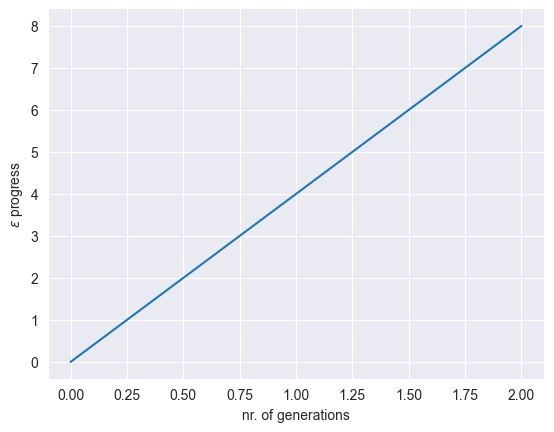

In [21]:
convergence = pd.read_pickle(r'../generated_datasets/initial_Pareto_policies_convergence.pkl')

plt.plot(convergence.epsilon_progress)
plt.xlabel("nr. of generations")
plt.ylabel(r"$\epsilon$ progress")
sns.despine()
plt.savefig(r'../Visualizations/MOEA/epsilon_progress_robust_optimize.png', bbox_inches='tight')
plt.show()
sns.set(rc={'figure.figsize':(12,6)})


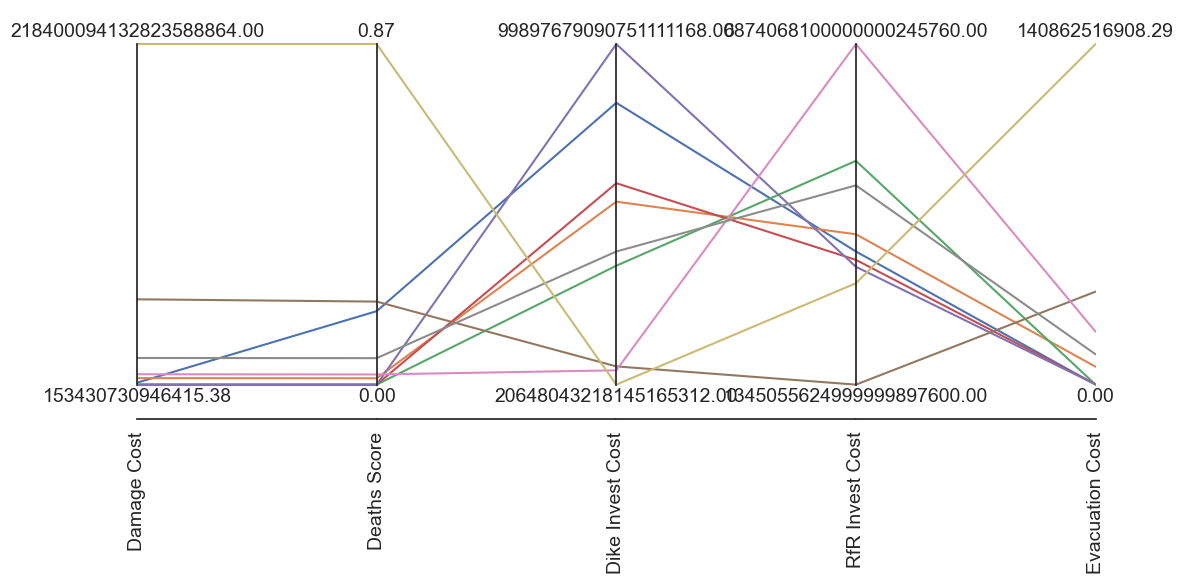

In [23]:
df = pd.read_pickle(r'../generated_datasets/initial_Pareto_policies.pkl')

data = df.loc[:, [o.name for o in robustness_functions]]
limits = parcoords.get_limits(data)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
sns.despine()
plt.savefig(r'../visualizations/MOEA/pareto_visualization.png', bbox_inches='tight')
sns.set(rc={'figure.figsize': (12, 6)})